<a href="https://colab.research.google.com/github/davinnnnn/Speech-Command/blob/main/speech_command_classification_with_torchaudio_tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# 그래프를 셸 결과창에 나타나게하는 명령어

%matplotlib inline

!pip install pydub # 이 명령은 pydub 패키지를 설치하는 명령입니다. pydub는 오디오 파일 처리를 위한 패키지입니다.

import sys  # sys 모듈을 임포트합니다. sys 모듈은 시스템과 관련된 기능을 제공합니다.



"speech command classification with torchaudio" 튜토리얼에서 사용되는 모델은 Convolutional Neural Network (CNN)과 Recurrent Neural Network (RNN)을 결합한 형태로, 음성 명령을 분류하기 위한 효과적인 동작원리를 제공한다. 이 모델은 음성 신호의 스펙트로그램(시간에 따른 주파수 변화를 시각화하는 방법)을 입력으로 사용한다.



# Speech Command Classification with torchaudio

This tutorial will show you how to correctly format an audio dataset and
then train/test an audio classifier network on the dataset.

Colab has GPU option available. In the menu tabs, select “Runtime” then
“Change runtime type”. In the pop-up that follows, you can choose GPU.
After the change, your runtime should automatically restart (which means
information from executed cells disappear).

First, let’s import the common torch packages such as
[torchaudio](https://github.com/pytorch/audio)_ that can be installed
by following the instructions on the website.


이 튜토리얼은 오디오 데이터셋의 올바른 형식을 만드는 방법과 해당 데이터셋에서 오디오 분류 네트워크를 훈련 및 테스트하는 방법을 보여줍니다. Colab에서는 GPU 옵션이 제공됩니다. 메뉴 탭에서 'Runtime'을 선택한 다음 'Change runtime type'을 선택합니다. 이후 나타나는 팝업에서 GPU를 선택할 수 있습니다. 변경 후에는 런타임이 자동으로 다시 시작됩니다 (이는 실행된 셀의 정보가 사라진다는 의미입니다). 먼저 웹사이트의 지침을 따라 설치할 수 있는 torchaudio와 같은 공통 torch 패키지를 가져오겠습니다

In [2]:
# Uncomment the line corresponding to your "runtime type" to run in Google Colab

# CPU:
# !pip install pydub torch==1.7.0+cpu torchvision==0.8.1+cpu torchaudio==0.7.0 -f https://download.pytorch.org/whl/torch_stable.html

# GPU:
# !pip install pydub torch==1.7.0+cu101 torchvision==0.8.1+cu101 torchaudio==0.7.0 -f https://download.pytorch.org/whl/torch_stable.html

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchaudio
import sys

import matplotlib.pyplot as plt
import IPython.display as ipd

from tqdm import tqdm


Let’s check if a CUDA GPU is available and select our device. Running
the network on a GPU will greatly decrease the training/testing runtime.




In [3]:
# cuda 지원여부 안되면 cpu 사용
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cpu


## Importing the Dataset

We use torchaudio to download and represent the dataset. Here we use
[SpeechCommands](https://arxiv.org/abs/1804.03209)_, which is a
datasets of 35 commands spoken by different people. The dataset
``SPEECHCOMMANDS`` is a ``torch.utils.data.Dataset`` version of the
dataset. In this dataset, all audio files are about 1 second long (and
so about 16000 time frames long).

The actual loading and formatting steps happen when a data point is
being accessed, and torchaudio takes care of converting the audio files
to tensors. If one wants to load an audio file directly instead,
``torchaudio.load()`` can be used. It returns a tuple containing the
newly created tensor along with the sampling frequency of the audio file
(16kHz for SpeechCommands).

Going back to the dataset, here we create a subclass that splits it into
standard training, validation, testing subsets.




데이터셋을 가져오는 과정"에 관한 내용을 설명하고 있습니다. 이 튜토리얼에서는 torchaudio를 사용하여 데이터셋을 다운로드하고 표현함.
(데이터셋 소개, 데이터셋 로딩 및 포맷틸, 데이터셋 분할)

이 단계들은 데이터셋을 준비하고 모델을 훈련시키기 위한 기초적인 단계입니다. 데이터셋을 효과적으로 로드하고 포맷하는 것

In [4]:
from torchaudio.datasets import SPEECHCOMMANDS # torchaudio의 SPEECHCOMMANDS 데이터셋을 임포트
import os # os 모듈을 임포트

# SubsetSC 클래스 정의: SPEECHCOMMANDS 데이터셋을 subset(훈련, 테스트 등)에 따라 분할하는 클래스

class SubsetSC(SPEECHCOMMANDS):
    def __init__(self, subset: str = None):
        super().__init__("./", download=True) # 슈퍼클래스(SPEECHCOMMANDS)의 생성자를 호출하여 데이터셋을 현재 디렉토리에서 다운로드

        def load_list(filename): # 파일을 읽어오는 함수를 정의
            filepath = os.path.join(self._path, filename) # 파일 경로를 지정합니다.
            with open(filepath) as fileobj: # 파일을 열고 사용한 후 자동으로 닫아주는 코드
                return [os.path.normpath(os.path.join(self._path, line.strip())) for line in fileobj] # 파일을 읽어서 각 라인의 내용을 리스트로 반환

        if subset == "validation":  # subset 변수에 따라 데이터셋을 로드
            self._walker = load_list("validation_list.txt") # "validation_list.txt" 파일을 읽어와서 self._walker에 할당
        elif subset == "testing":
            self._walker = load_list("testing_list.txt") #'testing_list.txt' 파일을 읽어와서 self._walker에 할당
        elif subset == "training":
            excludes = load_list("validation_list.txt") + load_list("testing_list.txt") # 'training' subset을 생성하기 위해 'validation_list.txt'와 'testing_list.txt' 파일을 읽어오기
            excludes = set(excludes) # 중복된 파일 경로를 제거하기 위해 중복을 제외한 파일 경로를 'excludes' 변수에 저장
            self._walker = [w for w in self._walker if w not in excludes] # 현재 데이터셋(self._walker)에서 'excludes'에 있는 파일 경로들을 제외한 새로운 데이터셋을 생성


# SubsetSC 클래스나 함수를 이용하여 학습용 데이터셋 서브셋을 생성
train_set = SubsetSC("training")

# SubsetSC 클래스나 함수를 이용하여 테스트용 데이터셋 서브셋을 생성
test_set = SubsetSC("testing")

# 학습 데이터셋에서 첫 번째 항목을 가져옵니다.
# waveform: 발화의 오디오 파형
# sample_rate: 오디오 파형의 샘플링 속도
# label: 발화의 라벨 또는 카테고리
# speaker_id: 발화를 한 사람의 식별자
# utterance_number: 발화자에 대한 이 특정 발화의 번호
waveform, sample_rate, label, speaker_id, utterance_number = train_set[0]


100%|██████████| 2.26G/2.26G [00:49<00:00, 48.9MB/s]


A data point in the SPEECHCOMMANDS dataset is a tuple made of a waveform
(the audio signal), the sample rate, the utterance (label), the ID of
the speaker, the number of the utterance.




Shape of waveform: torch.Size([1, 16000])
Sample rate of waveform: 16000


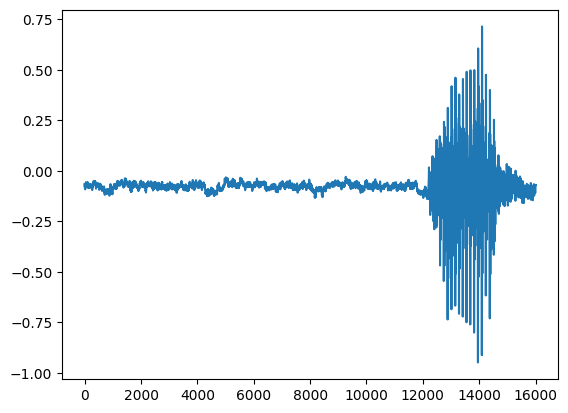

In [5]:
# waveform의 크기(차원)를 출력합니다.
print("Shape of waveform: {}".format(waveform.size()))

# waveform의 샘플링 속도를 출력합니다.
print("Sample rate of waveform: {}".format(sample_rate))

# waveform을 플롯으로 시각화합니다. .t() 메서드를 이용해 텐서를 전치하고, numpy() 메서드로 numpy 배열로 변환합니다.
plt.plot(waveform.t().numpy());


Let’s find the list of labels available in the dataset.




In [6]:
# train_set 내 모든 데이터 포인트로부터 라벨(인덱스 2에 위치)을 추출하고,
# 이를 집합(set)으로 변환하여 중복을 제거한 후, 다시 리스트로 변환하고 정렬합니다.
labels = sorted(list(set(datapoint[2] for datapoint in train_set)))

# 정렬된 라벨 리스트를 출력합니다.
labels


['backward',
 'bed',
 'bird',
 'cat',
 'dog',
 'down',
 'eight',
 'five',
 'follow',
 'forward',
 'four',
 'go',
 'happy',
 'house',
 'learn',
 'left',
 'marvin',
 'nine',
 'no',
 'off',
 'on',
 'one',
 'right',
 'seven',
 'sheila',
 'six',
 'stop',
 'three',
 'tree',
 'two',
 'up',
 'visual',
 'wow',
 'yes',
 'zero']

The 35 audio labels are commands that are said by users. The first few
files are people saying “marvin”.




In [7]:
# train_set의 첫 번째 항목에서 waveform을 추출합니다.
# *_는 나머지 항목들을 무시하겠다는 의미입니다.
waveform_first, *_ = train_set[0]

# 추출한 첫 번째 waveform을 Audio 형식으로 변환하여 재생합니다.
ipd.Audio(waveform_first.numpy(), rate=sample_rate)

# train_set의 두 번째 항목에서 waveform을 추출합니다.
waveform_second, *_ = train_set[1]

# 추출한 두 번째 waveform을 Audio 형식으로 변환하여 재생합니다.
ipd.Audio(waveform_second.numpy(), rate=sample_rate)


The last file is someone saying “visual”.




In [8]:
# train_set의 마지막 항목에서 waveform을 추출합니다.
# *_는 나머지 항목들을 무시하겠다는 의미입니다.
waveform_last, *_ = train_set[-1]

# 추출한 마지막 waveform을 Audio 형식으로 변환하여 재생합니다.
ipd.Audio(waveform_last.numpy(), rate=sample_rate)


## Formatting the Data

This is a good place to apply transformations to the data. For the
waveform, we downsample the audio for faster processing without losing
too much of the classification power.

We don’t need to apply other transformations here. It is common for some
datasets though to have to reduce the number of channels (say from
stereo to mono) by either taking the mean along the channel dimension,
or simply keeping only one of the channels. Since SpeechCommands uses a
single channel for audio, this is not needed here.




In [29]:
# 새로운 샘플률을 8000Hz로 설정합니다.
new_sample_rate = 8000

# 주어진 원래의 샘플률에서 새로운 샘플률로 리샘플링을 위한 변환 객체를 생성합니다.
transform = torchaudio.transforms.Resample(orig_freq=sample_rate, new_freq=new_sample_rate)

# 위에서 생성한 변환 객체를 이용하여 waveform을 리샘플링합니다.
transformed = transform(waveform)

# 리샘플링된 waveform을 Audio 형식으로 변환하여 재생합니다.
ipd.Audio(transformed.numpy(), rate=new_sample_rate)


We are encoding each word using its index in the list of labels.




In [10]:
# 주어진 단어(라벨)의 인덱스를 반환하는 함수입니다.
# 이 함수는 labels 리스트에서 주어진 단어의 위치를 찾아 반환합니다.
def label_to_index(word):
    return torch.tensor(labels.index(word))

# 주어진 인덱스에 해당하는 단어(라벨)를 반환하는 함수입니다.
# 이 함수는 label_to_index의 역함수로 작동합니다.
def index_to_label(index):
    return labels[index]

# 예제 단어와 그에 해당하는 인덱스를 찾아 출력하는 테스트 코드입니다.
word_start = "yes"
index = label_to_index(word_start)
word_recovered = index_to_label(index)
print(word_start, "-->", index, "-->", word_recovered)


yes --> tensor(33) --> yes


To turn a list of data point made of audio recordings and utterances
into two batched tensors for the model, we implement a collate function
which is used by the PyTorch DataLoader that allows us to iterate over a
dataset by batches. Please see [the
documentation](https://pytorch.org/docs/stable/data.html#working-with-collate-fn)_
for more information about working with a collate function.

In the collate function, we also apply the resampling, and the text
encoding.




In [11]:
# 주어진 배치의 텐서들의 길이를 동일하게 만들기 위한 함수 정의
def pad_sequence(batch):
    # 각 텐서를 전치하여 시간 차원이 앞으로 오게 합니다.
    batch = [item.t() for item in batch]

    # 각 텐서의 길이를 동일하게 맞춰주는 작업 (짧은 텐서는 0으로 패딩됩니다.)
    batch = torch.nn.utils.rnn.pad_sequence(batch, batch_first=True, padding_value=0.)

    # 전치된 텐서를 다시 원래대로 복귀시킵니다.
    return batch.permute(0, 2, 1)

# DataLoader에서 사용할 함수 정의 (배치 단위로 데이터를 처리)
def collate_fn(batch):
    # 각 데이터의 형태: waveform(오디오 데이터), sample_rate(샘플링 주파수), label(레이블), speaker_id(화자 ID), utterance_number(발화 번호)

    # 처리된 텐서와 목표값을 저장할 두 개의 리스트 초기화
    tensors, targets = [], []

    # 각 배치 데이터에 대한 처리
    for waveform, _, label, *_ in batch:
        # 현재 waveform을 텐서 리스트에 추가
        tensors += [waveform]

        # 현재 라벨을 인덱스로 변환하여 목표 리스트에 추가
        targets += [label_to_index(label)]

    # 각 텐서의 길이를 동일하게 맞춰주는 함수 호출
    tensors = pad_sequence(tensors)

    # 목표값들을 텐서로 변환
    targets = torch.stack(targets)

    return tensors, targets

# 배치의 크기를 256으로 설정
batch_size = 256

# 현재 디바이스가 GPU(cuda)인지 CPU인지 확인하고 그에 따라 설정
if device == "cuda":
    num_workers = 1   # GPU에서 사용할 워커 수
    pin_memory = True # GPU 메모리 최적화 옵션 활성화
else:
    num_workers = 0   # CPU에서는 워커를 사용하지 않음
    pin_memory = False

# 학습 데이터셋에 대한 DataLoader 설정
# 배치 사이즈, 셔플, 데이터 처리 함수, 워커 수 등의 옵션 설정
train_loader = torch.utils.data.DataLoader(
    train_set,
    batch_size=batch_size,
    shuffle=True,
    collate_fn=collate_fn,
    num_workers=num_workers,
    pin_memory=pin_memory,
)

# 테스트 데이터셋에 대한 DataLoader 설정
# 학습 데이터셋과 유사한 옵션을 사용하되, 셔플 옵션은 비활성화
test_loader = torch.utils.data.DataLoader(
    test_set,
    batch_size=batch_size,
    shuffle=False,
    drop_last=False,
    collate_fn=collate_fn,
    num_workers=num_workers,
    pin_memory=pin_memory,
)


## Define the Network

For this tutorial we will use a convolutional neural network to process
the raw audio data. Usually more advanced transforms are applied to the
audio data, however CNNs can be used to accurately process the raw data.
The specific architecture is modeled after the M5 network architecture
described in [this paper](https://arxiv.org/pdf/1610.00087.pdf)_. An
important aspect of models processing raw audio data is the receptive
field of their first layer’s filters. Our model’s first filter is length
80 so when processing audio sampled at 8kHz the receptive field is
around 10ms (and at 4kHz, around 20 ms). This size is similar to speech
processing applications that often use receptive fields ranging from
20ms to 40ms.




In [12]:
# M5라는 이름의 신경망 모델 클래스를 정의합니다.
class M5(nn.Module):
    # 초기화 함수
    def __init__(self, n_input=1, n_output=35, stride=16, n_channel=32):
        # 상위 클래스인 nn.Module의 초기화 함수를 호출합니다.
        super().__init__()

        # 첫 번째 합성곱 층 (1차원)
        self.conv1 = nn.Conv1d(n_input, n_channel, kernel_size=80, stride=stride)
        # 첫 번째 배치 정규화 층
        self.bn1 = nn.BatchNorm1d(n_channel)
        # 첫 번째 최대 풀링 층
        self.pool1 = nn.MaxPool1d(4)

        # 두 번째 합성곱 층
        self.conv2 = nn.Conv1d(n_channel, n_channel, kernel_size=3)
        # 두 번째 배치 정규화 층
        self.bn2 = nn.BatchNorm1d(n_channel)
        # 두 번째 최대 풀링 층
        self.pool2 = nn.MaxPool1d(4)

        # 세 번째 합성곱 층
        self.conv3 = nn.Conv1d(n_channel, 2 * n_channel, kernel_size=3)
        # 세 번째 배치 정규화 층
        self.bn3 = nn.BatchNorm1d(2 * n_channel)
        # 세 번째 최대 풀링 층
        self.pool3 = nn.MaxPool1d(4)

        # 네 번째 합성곱 층
        self.conv4 = nn.Conv1d(2 * n_channel, 2 * n_channel, kernel_size=3)
        # 네 번째 배치 정규화 층
        self.bn4 = nn.BatchNorm1d(2 * n_channel)
        # 네 번째 최대 풀링 층
        self.pool4 = nn.MaxPool1d(4)

        # 완전 연결 층
        self.fc1 = nn.Linear(2 * n_channel, n_output)

    # 순전파 함수
    def forward(self, x):
        # 각 층을 순서대로 통과시키면서 연산을 수행
        x = self.conv1(x)
        x = F.relu(self.bn1(x))
        x = self.pool1(x)

        x = self.conv2(x)
        x = F.relu(self.bn2(x))
        x = self.pool2(x)

        x = self.conv3(x)
        x = F.relu(self.bn3(x))
        x = self.pool3(x)

        x = self.conv4(x)
        x = F.relu(self.bn4(x))
        x = self.pool4(x)

        # 평균 풀링을 적용
        x = F.avg_pool1d(x, x.shape[-1])

        # 차원의 순서를 바꿈
        x = x.permute(0, 2, 1)

        # 완전 연결 층을 통과
        x = self.fc1(x)

        # 로그-소프트맥스 활성화 함수를 적용
        return F.log_softmax(x, dim=2)

# 모델 객체 생성
model = M5(n_input=transformed.shape[0], n_output=len(labels))
# 모델을 지정된 디바이스로 이동
model.to(device)
# 모델의 구조를 출력
print(model)

# 모델의 파라미터 수를 세는 함수
def count_parameters(model):
    # 모델의 학습 가능한 파라미터 수를 합산
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

# 모델의 학습 가능한 파라미터 수를 계산하고 출력
n = count_parameters(model)
print("Number of parameters: %s" % n)


M5(
  (conv1): Conv1d(1, 32, kernel_size=(80,), stride=(16,))
  (bn1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool1): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv1d(32, 32, kernel_size=(3,), stride=(1,))
  (bn2): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool2): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv1d(32, 64, kernel_size=(3,), stride=(1,))
  (bn3): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool3): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (conv4): Conv1d(64, 64, kernel_size=(3,), stride=(1,))
  (bn4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool4): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=64, out_features=35, bias=True)
)
Numbe

We will use the same optimization technique used in the paper, an Adam
optimizer with weight decay set to 0.0001. At first, we will train with
a learning rate of 0.01, but we will use a ``scheduler`` to decrease it
to 0.001 during training after 20 epochs.




In [13]:
# Optimizer 설정:
# Adam 최적화 알고리즘을 사용하며, 학습률은 0.01, 가중치 감소(Regularization)를 위한 매개변수는 0.0001로 설정합니다.
optimizer = optim.Adam(model.parameters(), lr=0.01, weight_decay=0.0001)

# 학습률 스케줄러 설정:
# 20 에폭마다 학습률을 0.1의 요인(factor)으로 감소시킵니다.
# 예를 들어, 초기 학습률이 0.01이라면 20 에폭 후에는 0.001로 감소됩니다.
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.1)


## Training and Testing the Network

Now let’s define a training function that will feed our training data
into the model and perform the backward pass and optimization steps. For
training, the loss we will use is the negative log-likelihood. The
network will then be tested after each epoch to see how the accuracy
varies during the training.




In [14]:
# 학습 함수 정의
def train(model, epoch, log_interval):

    # 모델을 학습 모드로 설정
    model.train()

    # 학습 데이터셋의 각 배치에 대해 반복
    for batch_idx, (data, target) in enumerate(train_loader):

        # 데이터와 타겟을 지정된 디바이스(CPU or GPU)로 이동
        data = data.to(device)
        target = target.to(device)

        # 데이터에 전처리(여기서는 Resample)을 적용하고 모델을 통해 출력값 계산
        data = transform(data)
        output = model(data)

        # Negative Log Likelihood 손실을 계산
        # 출력 텐서의 크기는 (batch x 1 x n_output)이므로 squeeze 함수로 차원을 줄인 후 손실을 계산
        loss = F.nll_loss(output.squeeze(), target)

        # 모델의 그라디언트를 초기화
        optimizer.zero_grad()

        # 손실에 대한 그라디언트를 역전파
        loss.backward()

        # 옵티마이저를 사용하여 모델의 파라미터 업데이트
        optimizer.step()

        # 일정 간격으로 학습 통계 출력
        if batch_idx % log_interval == 0:
            print(f"Train Epoch: {epoch} [{batch_idx * len(data)}/{len(train_loader.dataset)} ({100. * batch_idx / len(train_loader):.0f}%)]\tLoss: {loss.item():.6f}")

        # 진행 상태 업데이트 (이 부분은 본래 코드에 없던 pbar에 대한 것으로, 진행률 표시바를 업데이트하는 것으로 보임)
        pbar.update(pbar_update)

        # 손실값 기록 (losses는 이 함수 외부에 정의된 리스트로 추정됨)
        losses.append(loss.item())


Now that we have a training function, we need to make one for testing
the networks accuracy. We will set the model to ``eval()`` mode and then
run inference on the test dataset. Calling ``eval()`` sets the training
variable in all modules in the network to false. Certain layers like
batch normalization and dropout layers behave differently during
training so this step is crucial for getting correct results.




In [15]:
# 올바른 예측의 개수를 반환하는 함수
def number_of_correct(pred, target):
    return pred.squeeze().eq(target).sum().item()

# 배치의 각 요소에 대한 가장 가능성 있는 라벨 인덱스를 찾는 함수
def get_likely_index(tensor):
    return tensor.argmax(dim=-1)

# 테스트 함수 정의
def test(model, epoch):

    # 모델을 평가 모드로 설정 (dropout 및 batchnorm 등의 행동을 변경)
    model.eval()
    correct = 0  # 올바른 예측의 개수를 저장하기 위한 변수

    # 테스트 데이터셋의 각 배치에 대해 반복
    for data, target in test_loader:

        # 데이터와 타겟을 지정된 디바이스(CPU or GPU)로 이동
        data = data.to(device)
        target = target.to(device)

        # 데이터에 전처리(Resample)을 적용하고 모델을 통해 출력값 계산
        data = transform(data)
        output = model(data)

        # 출력값에서 가장 가능성 있는 라벨 인덱스를 추출
        pred = get_likely_index(output)

        # 올바른 예측의 개수를 누적
        correct += number_of_correct(pred, target)

        # 진행 상태 업데이트 (pbar는 진행률 표시바를 업데이트하는 것으로 보임)
        pbar.update(pbar_update)

    # 테스트 결과 출력
    print(f"\nTest Epoch: {epoch}\tAccuracy: {correct}/{len(test_loader.dataset)} ({100. * correct / len(test_loader.dataset):.0f}%)\n")


Finally, we can train and test the network. We will train the network
for ten epochs then reduce the learn rate and train for ten more epochs.
The network will be tested after each epoch to see how the accuracy
varies during the training.




  0%|          | 0.0026666666666666666/2 [00:02<30:10, 906.42s/it]

Train Epoch: 1 [0/84843 (0%)]	Loss: 3.730706


  3%|▎         | 0.05599999999999999/2 [00:11<04:46, 147.14s/it]

Train Epoch: 1 [5120/84843 (6%)]	Loss: 3.175025


  5%|▌         | 0.10933333333333328/2 [00:19<04:10, 132.57s/it]

Train Epoch: 1 [10240/84843 (12%)]	Loss: 2.599618


  8%|▊         | 0.16266666666666676/2 [00:28<05:25, 177.09s/it]

Train Epoch: 1 [15360/84843 (18%)]	Loss: 2.281661


 11%|█         | 0.21600000000000033/2 [00:36<04:22, 146.88s/it]

Train Epoch: 1 [20480/84843 (24%)]	Loss: 2.102035


 13%|█▎        | 0.2693333333333337/2 [00:44<04:37, 160.31s/it] 

Train Epoch: 1 [25600/84843 (30%)]	Loss: 1.904135


 16%|█▌        | 0.3226666666666667/2 [00:52<03:58, 142.21s/it] 

Train Epoch: 1 [30720/84843 (36%)]	Loss: 1.786913


 19%|█▉        | 0.3759999999999997/2 [01:00<03:51, 142.84s/it]

Train Epoch: 1 [35840/84843 (42%)]	Loss: 1.842941


 21%|██▏       | 0.42933333333333273/2 [01:08<04:53, 186.68s/it]

Train Epoch: 1 [40960/84843 (48%)]	Loss: 1.749689


 24%|██▍       | 0.48266666666666574/2 [01:16<03:34, 141.66s/it]

Train Epoch: 1 [46080/84843 (54%)]	Loss: 1.743410


 27%|██▋       | 0.5359999999999995/2 [01:24<03:19, 136.08s/it]

Train Epoch: 1 [51200/84843 (60%)]	Loss: 1.471494


 29%|██▉       | 0.5893333333333336/2 [01:32<03:03, 130.20s/it]

Train Epoch: 1 [56320/84843 (66%)]	Loss: 1.507478


 32%|███▏      | 0.6426666666666677/2 [01:39<02:58, 131.47s/it]

Train Epoch: 1 [61440/84843 (72%)]	Loss: 1.364105


 35%|███▍      | 0.6960000000000018/2 [01:48<04:01, 184.89s/it]

Train Epoch: 1 [66560/84843 (78%)]	Loss: 1.266548


 37%|███▋      | 0.749333333333336/2 [01:55<02:59, 143.64s/it] 

Train Epoch: 1 [71680/84843 (84%)]	Loss: 1.414277


 40%|████      | 0.8026666666666701/2 [02:04<03:01, 151.38s/it]

Train Epoch: 1 [76800/84843 (90%)]	Loss: 1.144695


 43%|████▎     | 0.8560000000000042/2 [02:11<02:30, 131.90s/it]

Train Epoch: 1 [81920/84843 (96%)]	Loss: 1.224656


 50%|█████     | 1.0000000000000062/2 [02:27<02:15, 135.27s/it]


Test Epoch: 1	Accuracy: 6076/11005 (55%)



 50%|█████     | 1.0026666666666728/2 [02:28<02:43, 163.71s/it]

Train Epoch: 2 [0/84843 (0%)]	Loss: 1.117365


 53%|█████▎    | 1.0560000000000047/2 [02:36<02:12, 140.83s/it]

Train Epoch: 2 [5120/84843 (6%)]	Loss: 1.087515


 55%|█████▌    | 1.1093333333333366/2 [02:44<02:05, 140.43s/it]

Train Epoch: 2 [10240/84843 (12%)]	Loss: 0.960600


 58%|█████▊    | 1.1626666666666685/2 [02:52<01:56, 138.60s/it]

Train Epoch: 2 [15360/84843 (18%)]	Loss: 0.974267


 61%|██████    | 1.2160000000000004/2 [03:03<03:42, 283.36s/it]

Train Epoch: 2 [20480/84843 (24%)]	Loss: 1.121747


 63%|██████▎   | 1.2693333333333323/2 [03:14<01:45, 144.17s/it]

Train Epoch: 2 [25600/84843 (30%)]	Loss: 1.113994


 66%|██████▌   | 1.3226666666666642/2 [03:22<01:58, 174.47s/it]

Train Epoch: 2 [30720/84843 (36%)]	Loss: 1.218271


 69%|██████▉   | 1.3759999999999961/2 [03:29<01:22, 132.45s/it]

Train Epoch: 2 [35840/84843 (42%)]	Loss: 0.906772


 71%|███████▏  | 1.429333333333328/2 [03:38<01:36, 169.32s/it] 

Train Epoch: 2 [40960/84843 (48%)]	Loss: 0.846877


 74%|███████▍  | 1.48266666666666/2 [03:45<01:07, 129.63s/it]  

Train Epoch: 2 [46080/84843 (54%)]	Loss: 1.143475


 77%|███████▋  | 1.5359999999999918/2 [03:53<01:02, 134.59s/it]

Train Epoch: 2 [51200/84843 (60%)]	Loss: 0.914828


 79%|███████▉  | 1.5893333333333237/2 [04:02<01:19, 193.46s/it]

Train Epoch: 2 [56320/84843 (66%)]	Loss: 0.839619


 82%|████████▏ | 1.6426666666666556/2 [04:09<00:51, 144.40s/it]

Train Epoch: 2 [61440/84843 (72%)]	Loss: 1.039715


 85%|████████▍ | 1.6959999999999875/2 [04:18<00:43, 142.57s/it]

Train Epoch: 2 [66560/84843 (78%)]	Loss: 0.874742


 87%|████████▋ | 1.7493333333333194/2 [04:25<00:36, 144.54s/it]

Train Epoch: 2 [71680/84843 (84%)]	Loss: 0.923637


 90%|█████████ | 1.8026666666666513/2 [04:34<00:26, 133.05s/it]

Train Epoch: 2 [76800/84843 (90%)]	Loss: 0.820497


 93%|█████████▎| 1.8559999999999832/2 [04:42<00:27, 192.32s/it]

Train Epoch: 2 [81920/84843 (96%)]	Loss: 0.844079


100%|█████████▉| 1.9999999999999793/2 [05:04<00:00, 152.11s/it]



Test Epoch: 2	Accuracy: 7877/11005 (72%)



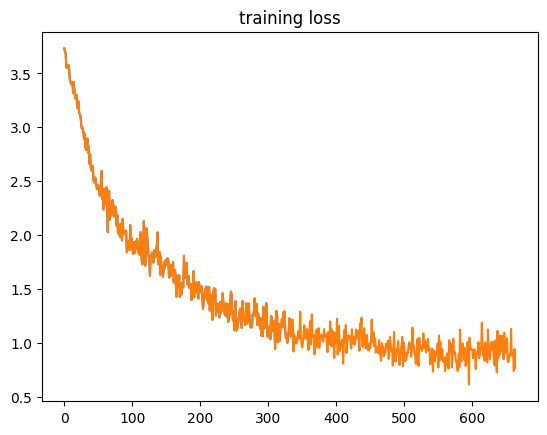

In [18]:
# 학습 및 테스트 시 로그를 기록할 간격을 설정합니다.
log_interval = 20

# 총 학습 에포크 수를 설정합니다.
n_epoch = 2

# tqdm의 진행 표시줄(progress bar)을 업데이트하기 위한 값 설정.
# 학습 데이터로더와 테스트 데이터로더의 전체 길이를 합한 값의 역수를 이용합니다.
pbar_update = 1 / (len(train_loader) + len(test_loader))

# 학습 도중의 손실(loss) 값을 저장할 리스트를 초기화합니다.
losses = []

# 변환(예: 데이터 전처리)을 수행하는 transform은
# 모델과 데이터와 같은 장치(device)에 있어야 합니다.
transform = transform.to(device)

# 진행 표시줄을 초기화하고 전체 학습 에포크 수만큼 반복합니다.
with tqdm(total=n_epoch) as pbar:
    for epoch in range(1, n_epoch + 1):
        # 학습 함수를 호출하며 모델, 현재 에포크, 로그 간격을 인수로 전달합니다.
        train(model, epoch, log_interval)

        # 테스트 함수를 호출하며 모델과 현재 에포크를 인수로 전달합니다.
        test(model, epoch)

        # 스케줄러를 사용하여 학습률을 조정합니다.
        scheduler.step()

# (선택사항) 학습 손실을 반복 횟수에 대하여 그래프로 그립니다.
        plt.plot(losses);
        plt.title("training loss");


The network should be more than 65% accurate on the test set after 2
epochs, and 85% after 21 epochs. Let’s look at the last words in the
train set, and see how the model did on it.




In [19]:
def predict(tensor):
    # 주어진 텐서(waveform)에 대해 라벨을 예측하기 위해 모델을 사용합니다.

    # 텐서를 모델과 동일한 장치(device)로 이동시킵니다.
    tensor = tensor.to(device)

    # 텐서에 데이터 전처리(transform)를 적용합니다.
    tensor = transform(tensor)

    # 전처리된 텐서를 모델에 입력하여 결과를 얻습니다.
    # unsqueeze(0)은 배치 차원을 추가하기 위해 사용됩니다.
    tensor = model(tensor.unsqueeze(0))

    # tensor에서 가장 확률이 높은 인덱스를 가져옵니다.
    tensor = get_likely_index(tensor)

    # 인덱스를 해당하는 라벨로 변환합니다.
    tensor = index_to_label(tensor.squeeze())

    return tensor

# 학습 데이터셋의 마지막 샘플을 가져옵니다.
waveform, sample_rate, utterance, *_ = train_set[-1]

# 가져온 waveform을 오디오로 재생할 수 있게 ipd.Audio를 사용하여 오디오 객체를 생성합니다.
ipd.Audio(waveform.numpy(), rate=sample_rate)

# 예측된 라벨과 실제 라벨(utterance)을 출력합니다.
print(f"Expected: {utterance}. Predicted: {predict(waveform)}.")


Expected: zero. Predicted: zero.


Let’s find an example that isn’t classified correctly, if there is one.




In [20]:
# 테스트 데이터셋을 순회합니다.
for i, (waveform, sample_rate, utterance, *_) in enumerate(test_set):
    # 현재 waveform에 대한 라벨을 예측합니다.
    output = predict(waveform)

    # 예측된 라벨과 실제 라벨이 다르다면,
    if output != utterance:
        # 해당 waveform을 오디오로 재생합니다.
        ipd.Audio(waveform.numpy(), rate=sample_rate)

        # 해당 데이터 포인트의 정보를 출력합니다.
        print(f"Data point #{i}. Expected: {utterance}. Predicted: {output}.")

        # 첫 번째 예측 오류를 찾았으므로 반복을 중단합니다.
        break
else:
    # 모든 데이터 포인트에서 예측이 올바르게 이루어졌다면,
    print("All examples in this dataset were correctly classified!")

    # 이 경우, 마지막 데이터 포인트에 대한 정보만 출력합니다.
    print("In this case, let's just look at the last data point")
    print(f"Data point #{i}. Expected: {utterance}. Predicted: {output}.")


Data point #1. Expected: right. Predicted: learn.


Feel free to try with one of your own recordings of one of the labels!
For example, using Colab, say “Go” while executing the cell below. This
will record one second of audio and try to classify it.




In [28]:
def record(seconds=4):

    # Google Colab의 출력 기능과 관련된 라이브러리들을 임포트합니다.
    from google.colab import output as colab_output
    from base64 import b64decode
    from io import BytesIO
    from pydub import AudioSegment

    # 웹 브라우저에서 오디오를 녹음하기 위한 자바스크립트 코드입니다.
    # 이 코드는 사용자의 마이크를 통해 지정된 시간동안 오디오를 녹음합니다.
    RECORD = (
        b"const sleep  = time => new Promise(resolve => setTimeout(resolve, time))\n"
        b"const b2text = blob => new Promise(resolve => {\n"
        b"  const reader = new FileReader()\n"
        b"  reader.onloadend = e => resolve(e.srcElement.result)\n"
        b"  reader.readAsDataURL(blob)\n"
        b"})\n"
        b"var record = time => new Promise(async resolve => {\n"
        b"  stream = await navigator.mediaDevices.getUserMedia({ audio: true })\n"
        b"  recorder = new MediaRecorder(stream)\n"
        b"  chunks = []\n"
        b"  recorder.ondataavailable = e => chunks.push(e.data)\n"
        b"  recorder.start()\n"
        b"  await sleep(time)\n"
        b"  recorder.onstop = async ()=>{\n"
        b"    blob = new Blob(chunks)\n"
        b"    text = await b2text(blob)\n"
        b"    resolve(text)\n"
        b"  }\n"
        b"  recorder.stop()\n"
        b"})"
    )
    RECORD = RECORD.decode("ascii")

    # 녹음이 시작됨을 알립니다.
    print(f"Recording started for {seconds} seconds.")
    display(ipd.Javascript(RECORD))
    s = colab_output.eval_js("record(%d)" % (seconds * 1000))
    print("Recording ended.")
    b = b64decode(s.split(",")[1])

    # 녹음된 오디오를 wav 형식으로 저장합니다
    fileformat = "wav"
    filename = f"_audio.{fileformat}"
    AudioSegment.from_file(BytesIO(b)).export(filename, format=fileformat)
    return torchaudio.load(filename)


# Detect whether notebook runs in google colab
if "google.colab" in sys.modules:
    waveform, sample_rate = record()
    print(f"Predicted: {predict(waveform)}.")
    ipd.Audio(waveform.numpy(), rate=sample_rate)

Recording started for 4 seconds.


<IPython.core.display.Javascript object>

Recording ended.
Predicted: four.


## Conclusion

In this tutorial, we used torchaudio to load a dataset and resample the
signal. We have then defined a neural network that we trained to
recognize a given command. There are also other data preprocessing
methods, such as finding the mel frequency cepstral coefficients (MFCC),
that can reduce the size of the dataset. This transform is also
available in torchaudio as ``torchaudio.transforms.MFCC``.


